In [160]:
from segment.modules.semibase import Base
from segment.modules.semseg.deeplabv3plus import DeepLabV3Plus
import torch
from torchvision import transforms as T
from torchvision.transforms import functional as F
import torch.nn as nn
from PIL import Image
import numpy as np
from segment.util import  color_map
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [161]:
num_classes = 3
ckpt_path = '../temp/val_OD_dice=0.847466.ckpt'

cmap = color_map('eye')

model = DeepLabV3Plus('resnet50',num_classes)

sd = torch.load(ckpt_path, map_location='cpu')['state_dict']
if 'state_dict' in sd:
    # If 'state_dict' exists, use it directly
    sd = sd['state_dict']
new_state_dict = {}
for key, value in sd.items():
    # if not key.startswith('module.'):  # 如果关键字没有"module."前缀，加上该前缀
    #     if 'module.' + key in model.state_dict():
    #         # 模型在多GPU上训练并保存，加载权重时加上"module."前缀
    #         key = 'module.' + key
    key = key.replace('model.', '')
    new_state_dict[key] = value
model.load_state_dict(new_state_dict)
model.eval()


image_path = './T0001.jpg'
mask_path = './T0001.bmp'
image_tensor = T.ToTensor()(Image.open(image_path)).unsqueeze(dim=0)
mask_tensor = torch.tensor(np.array((Image.open(mask_path)))).squeeze()


output = model(image_tensor)
backbone_feat, logits = output['backbone_features'], output['out']

In [162]:
pred = nn.functional.softmax(logits, dim=1).argmax(1).squeeze()
print(pred.shape)

torch.Size([512, 512])


In [163]:
zero_indices = torch.nonzero(pred==0)
od_indices = torch.nonzero(torch.eq(pred,1))
oc_indices = torch.nonzero(torch.eq(pred,2))
print(zero_indices.shape)
print(od_indices.shape)
print(oc_indices.shape)

torch.Size([215215, 2])
torch.Size([35455, 2])
torch.Size([11474, 2])


In [164]:
logits = logits.squeeze()
print(logits.shape)

torch.Size([3, 512, 512])


In [170]:
background_nums = 1000
od_nums = 1000
oc_nums = 1000
background_samples = [logits[:,i[0],i[1]].unsqueeze(dim=0) for i in zero_indices[:background_nums,:]]
od_samples = [logits[:,i[0],i[1]].unsqueeze(dim=0) for i in od_indices[:od_nums,:]]
oc_samples = [logits[:,i[0],i[1]].unsqueeze(dim=0) for i in oc_indices[:oc_nums,:]]
background_samples.extend(od_samples)
background_samples.extend(oc_samples)
all_samples = torch.cat(background_samples)
all_samples = all_samples.detach().numpy()

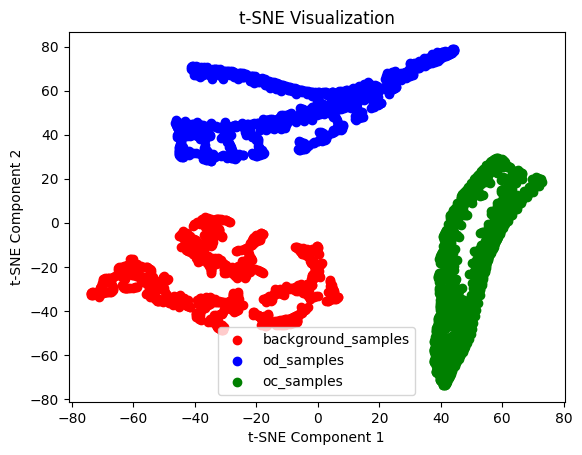

In [171]:
labels = np.zeros(all_samples.shape[0])
labels[background_nums:background_nums+od_nums] = 1
labels[background_nums+od_nums:] = 2
# 使用t-SNE进行降维，降至二维空间
perplexity = 30
learning_rate = 100
num_neighbors = 128
n_iter = 3500
# from tsnecuda import TSNE
# tsne = TSNE(n_components=2,perplexity=perplexity,learning_rate=100,metric='innerproduct',
#                  random_seed=304, num_neighbors=num_neighbors, n_iter=n_iter,)
tsne = TSNE(n_components=2,perplexity=perplexity,learning_rate=100,
                 random_state=304, n_iter=n_iter,)
data_tsne = tsne.fit_transform(all_samples)
# 根据样本标签使用不同的颜色绘制散点图
plt.scatter(data_tsne[:background_nums, 0], data_tsne[:background_nums, 1], label='background_samples', c='red')
plt.scatter(data_tsne[background_nums:background_nums+od_nums, 0], data_tsne[background_nums:background_nums+od_nums, 1], label='od_samples', c='blue')
plt.scatter(data_tsne[background_nums+od_nums:, 0], data_tsne[background_nums+od_nums:, 1], label='oc_samples', c='green')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.legend()
plt.show()